In [65]:
import sys
sys.path.append("../code/")

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR, LambdaLR, CosineAnnealingLR
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error

from swag import SWAG
from models import Regression_linear, Classification_relu, Classification_sigmoid, Classification_tanh, Classification_relu_8
from util import plot_decision_boundary, uncertainty_measurement, \
    model_param_to_1D, params_1d_to_weights, create_NN_with_weights, uncertainty_estimation
from data_gen import ClassificationDataSet, RegressionDataSet

import warnings
warnings.filterwarnings('ignore')
import random
torch.manual_seed(0)
np.random.seed(0)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Prior Choice

In the SWAG paper, the implicit prior of weights is achieved by using weight decay, specifically SGD with momentum. Typically, weight decay is used to regularize DNNs, corresponding to explicit L2 regularization when SGD without momentum is used to train the model. When SGD is used with momentum, as is typically the case, implicit regularization still occurs, producing a vague prior on the weights of the DNN in our procedure. This regularizer can be given an explicit Gaussian-like form (Proposition 3 of Loshchilov, I. and Hutter, F. (2019). Decoupled Weight Decay Regularization. In International Conference on Learning Representations. arXiv: 1711.05101.), corresponding to a prior distribution on the weights.

In the following, we first examine why weight decay and L2 regularization may reach equivalence effects in terms of SGD, then we will try alternative regularization techniques that producing different priors on the weights, and comparing the performance with what we have before.

L2 regularization can be proved equivalent to weight decay in the case of SGD in the following proof:  
Given a cost function $C_0$: we have $W = (1-\lambda)W - \alpha \Delta C_0$ as weight decay procedure.  
If we apply L2 regularization on the cost function, we have $C = C_0 + \frac{\lambda}{2} ||W||_2^2$ as the objective function.  
Tahking the partial derivative with respect to $W$, we have 
$\frac{\partial C}{\partial W} = \frac{\partial C_0}{\partial W} + 2\frac{\lambda}{2}W$.  
Hence, by doing gradient descent, we have:  
$$
\begin{equation} \label{eq1}
\begin{split}
W & = W - \alpha \Delta C_0 \\
  & = W - \alpha (\Delta C_0 + \lambda W)\\
  & = W = \alpha \Delta C_0 - \alpha \lambda W \\
  & = (1-\alpha \lambda)W - \alpha \Delta C_0
\end{split}
\end{equation}
$$
Thus, if we replacing $\lambda$ by $\frac{\lambda^"}{\lambda}$, we have $W = (1-\lambda^")W - \alpha \Delta C_0$ as weight decay procedure with decaying rate $\lambda^" = \alpha \lambda$

When SGD is used with momentum, as used in the SWAG paper, implicit regularization occurs, producing a vague prior on the weights of the DNN in our procedure. This regularizer can be given an explicit Gaussian-like form, corresponding to a prior distribution on the weights.  

Alternative regularization techniques could also be used, producing different priors on the weights. It may also be possible to similarly utilize Adam and other stochastic first-order method. Here, we try to evaluate the effectiveness of other optimizers.

### Classification Task
For the classification task, we compared the proformance of using SGD with Adam, RMSProp, AdamW, on the OOD classification toy dataset.  

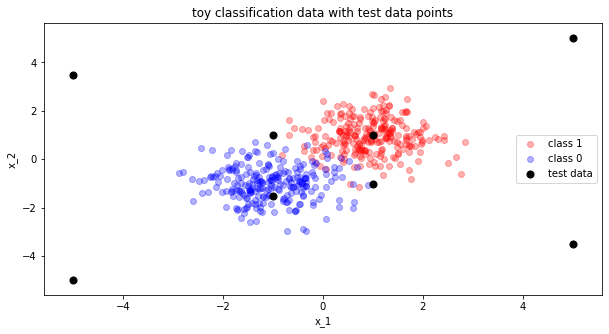

In [95]:
# Create the training DataSet
train_data = ClassificationDataSet(n_samples=500, mode='train')
train_gen = DataLoader(dataset = train_data, batch_size = 8, shuffle = False)

X, y, X_test = train_data.X, train_data.Y.flatten(), train_data.test_points

# Visualize our test data points
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(X[y == 1, 0], X[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(X[y == 0, 0], X[y == 0, 1], alpha=0.3, color='blue', label='class 0')
for i in range(len(X_test)):
    pt = X_test[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points')
ax.legend(loc='best')

In [96]:
# Initialize SWAG
swag = SWAG(Classification_relu, K = 10)
print("Total number of parameters for the NN is:", swag.weigt_D)

# Compile swag
objective = 'classification'
swa_const_lr = 1
optimizer = lambda parameters: optim.AdamW(parameters, lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
swa_scheduler = LambdaLR
swag.compile_customize_optimizer(objective, swa_const_lr, optimizer, loss_fn, swa_scheduler)

Total number of parameters for the NN is: 42


In [97]:
# Fit swag
first_mom, second_mom, D = swag.fit(train_gen,
                                    train_epoch=30,
                                    swag_epoch=20,
                                    log_freq=60)

Begin NN model training...
[Epoch: 1, 	Iteration:    60] 	Training Loss: 0.7002
[Epoch: 2, 	Iteration:    60] 	Training Loss: 0.6784
[Epoch: 3, 	Iteration:    60] 	Training Loss: 0.6576
[Epoch: 4, 	Iteration:    60] 	Training Loss: 0.6321
[Epoch: 5, 	Iteration:    60] 	Training Loss: 0.5950
[Epoch: 6, 	Iteration:    60] 	Training Loss: 0.5433
[Epoch: 7, 	Iteration:    60] 	Training Loss: 0.4863
[Epoch: 8, 	Iteration:    60] 	Training Loss: 0.4398
[Epoch: 9, 	Iteration:    60] 	Training Loss: 0.4094
[Epoch: 10, 	Iteration:    60] 	Training Loss: 0.3904
[Epoch: 11, 	Iteration:    60] 	Training Loss: 0.3784
[Epoch: 12, 	Iteration:    60] 	Training Loss: 0.3705
[Epoch: 13, 	Iteration:    60] 	Training Loss: 0.3650
[Epoch: 14, 	Iteration:    60] 	Training Loss: 0.3611
[Epoch: 15, 	Iteration:    60] 	Training Loss: 0.3582
[Epoch: 16, 	Iteration:    60] 	Training Loss: 0.3559
[Epoch: 17, 	Iteration:    60] 	Training Loss: 0.3542
[Epoch: 18, 	Iteration:    60] 	Training Loss: 0.3528
[Epoch: 19

In [98]:
# Sample 1000 posterior weights
expand_pred = swag.predict(torch.Tensor(X_test), [0, 1], S=100, expanded=True)
print("Shape of the expanded prediction:\n", expand_pred.shape)
print("Predictions for each point using the 1st sample weights:\n", expand_pred[0])

Shape of the expanded prediction:
 (100, 8, 2)
Predictions for each point using the 1st sample weights:
 [[9.34363902e-01 6.56361207e-02]
 [1.55664235e-01 8.44335794e-01]
 [9.99563634e-01 4.36405942e-04]
 [1.67781906e-03 9.98322189e-01]
 [9.94708896e-01 5.29114762e-03]
 [1.02739021e-01 8.97261024e-01]
 [8.03391874e-01 1.96608111e-01]
 [3.32745701e-01 6.67254329e-01]]


In [99]:
# Measure Uncertainty
uncertainty_measurement(X_test, expand_pred)


Begin uncertainty assessment...
Test point: (-1, -1.5) 	Variance in prediction: 0.0000
Test point: (1, 1) 	Variance in prediction: 0.0000
Test point: (-5, -5) 	Variance in prediction: 0.0000
Test point: (5, 5) 	Variance in prediction: 0.0000
Test point: (-5, 3.5) 	Variance in prediction: 0.1056
Test point: (5, -3.5) 	Variance in prediction: 0.2499
Test point: (-1, 1) 	Variance in prediction: 0.1924
Test point: (1, -1) 	Variance in prediction: 0.1875


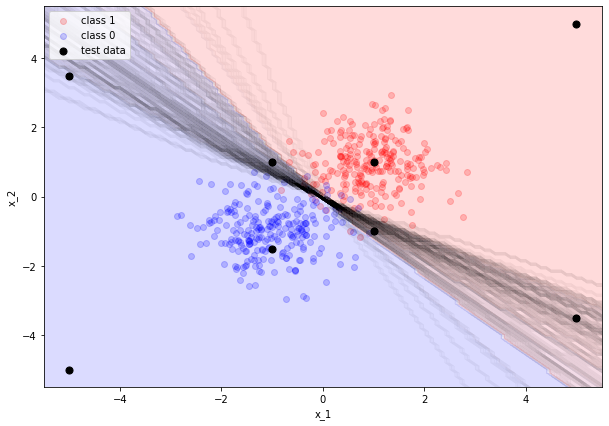

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plot_decision_boundary(swag, X, y, ax, xlim=6, n_models=100, poly_degree=1, test_points=X_test, shaded=True)

From the above result, we can see that the shapes of the decision boundaries do not change the original one, which means the model fails to detect OOD observations. Especially, it fails to capture epistemic uncertainty of (-5,-5), (5,5).

### Regression  
For the regression task, we compared the proformance of using SGD with Adam, RMSProp, AdamW, on the toy data set from HW2 for aleatoric and epistemic uncertainty estimation. To simplify the testing, we used the best parameter set found in the previous sections, and only changing the optimizer.  

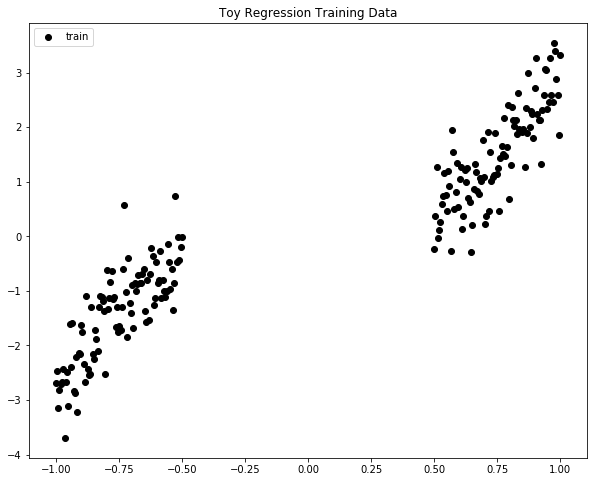

In [60]:
# Create the training DataSet for regression task
n_samples = 100
train_data = RegressionDataSet(n_samples=n_samples, mode='train',gap = True)
train_gen = DataLoader(dataset = train_data, batch_size = 1, shuffle = True)
X, y, X_test = train_data.X, train_data.Y.flatten(), train_data.X_test

valid_data = RegressionDataSet(n_samples=20, mode='train',gap=True)
X_valid, y_valid = valid_data.X, valid_data.Y.flatten()

# Visualize our training data points
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plt.scatter(X, y, color='black', label='train')
plt.title('Toy Regression Training Data')
plt.legend()

In [82]:
# Initialize SWAG
swag = SWAG(Regression_linear, K = 4)
print("Total number of parameters for the NN is:", swag.weigt_D)

# Compile swag
objective = 'regression'
swa_const_lr = 1
optimizer = lambda parameters: optim.Adam(parameters, lr=1e-2)
loss_fn = nn.MSELoss()
swa_scheduler = LambdaLR

swag.compile_customize_optimizer(objective, swa_const_lr, optimizer, loss_fn, swa_scheduler)

Total number of parameters for the NN is: 46


In [83]:
# Fit swag
first_mom, second_mom, D = swag.fit(train_gen,
                                    train_epoch=50,
                                    swag_epoch=20,
                                    log_freq=5,verbose=False)

Begin NN model training...
[Epoch: 1, 	Iteration:     5] 	Training Loss: 2.4218
[Epoch: 1, 	Iteration:    10] 	Training Loss: 3.6561
[Epoch: 1, 	Iteration:    15] 	Training Loss: 3.4573
[Epoch: 1, 	Iteration:    20] 	Training Loss: 0.6323
[Epoch: 1, 	Iteration:    25] 	Training Loss: 1.5781
[Epoch: 1, 	Iteration:    30] 	Training Loss: 1.0962
[Epoch: 1, 	Iteration:    35] 	Training Loss: 2.0490
[Epoch: 1, 	Iteration:    40] 	Training Loss: 0.2320
[Epoch: 1, 	Iteration:    45] 	Training Loss: 0.7424
[Epoch: 1, 	Iteration:    50] 	Training Loss: 0.5149
[Epoch: 1, 	Iteration:    55] 	Training Loss: 0.7691
[Epoch: 1, 	Iteration:    60] 	Training Loss: 0.1132
[Epoch: 1, 	Iteration:    65] 	Training Loss: 1.2432
[Epoch: 1, 	Iteration:    70] 	Training Loss: 0.6867
[Epoch: 1, 	Iteration:    75] 	Training Loss: 0.9236
[Epoch: 1, 	Iteration:    80] 	Training Loss: 0.2402
[Epoch: 1, 	Iteration:    85] 	Training Loss: 0.3482
[Epoch: 1, 	Iteration:    90] 	Training Loss: 0.3614
[Epoch: 1, 	Iterati

[Epoch: 5, 	Iteration:   125] 	Training Loss: 0.4485
[Epoch: 5, 	Iteration:   130] 	Training Loss: 0.5607
[Epoch: 5, 	Iteration:   135] 	Training Loss: 0.1795
[Epoch: 5, 	Iteration:   140] 	Training Loss: 0.4147
[Epoch: 5, 	Iteration:   145] 	Training Loss: 1.0986
[Epoch: 5, 	Iteration:   150] 	Training Loss: 0.4253
[Epoch: 5, 	Iteration:   155] 	Training Loss: 0.5971
[Epoch: 5, 	Iteration:   160] 	Training Loss: 0.2885
[Epoch: 5, 	Iteration:   165] 	Training Loss: 0.3681
[Epoch: 5, 	Iteration:   170] 	Training Loss: 0.7807
[Epoch: 5, 	Iteration:   175] 	Training Loss: 0.5515
[Epoch: 5, 	Iteration:   180] 	Training Loss: 0.0908
[Epoch: 5, 	Iteration:   185] 	Training Loss: 0.3141
[Epoch: 5, 	Iteration:   190] 	Training Loss: 0.2270
[Epoch: 5, 	Iteration:   195] 	Training Loss: 0.6593
[Epoch: 5, 	Iteration:   200] 	Training Loss: 0.3750
[Epoch: 6, 	Iteration:     5] 	Training Loss: 0.6156
[Epoch: 6, 	Iteration:    10] 	Training Loss: 0.1856
[Epoch: 6, 	Iteration:    15] 	Training Loss: 

[Epoch: 10, 	Iteration:   100] 	Training Loss: 0.2535
[Epoch: 10, 	Iteration:   105] 	Training Loss: 0.1522
[Epoch: 10, 	Iteration:   110] 	Training Loss: 0.1231
[Epoch: 10, 	Iteration:   115] 	Training Loss: 0.2609
[Epoch: 10, 	Iteration:   120] 	Training Loss: 0.5701
[Epoch: 10, 	Iteration:   125] 	Training Loss: 0.0953
[Epoch: 10, 	Iteration:   130] 	Training Loss: 0.0537
[Epoch: 10, 	Iteration:   135] 	Training Loss: 0.1040
[Epoch: 10, 	Iteration:   140] 	Training Loss: 0.4914
[Epoch: 10, 	Iteration:   145] 	Training Loss: 0.2066
[Epoch: 10, 	Iteration:   150] 	Training Loss: 0.1996
[Epoch: 10, 	Iteration:   155] 	Training Loss: 0.7373
[Epoch: 10, 	Iteration:   160] 	Training Loss: 0.2251
[Epoch: 10, 	Iteration:   165] 	Training Loss: 0.2345
[Epoch: 10, 	Iteration:   170] 	Training Loss: 0.2553
[Epoch: 10, 	Iteration:   175] 	Training Loss: 0.1982
[Epoch: 10, 	Iteration:   180] 	Training Loss: 0.0374
[Epoch: 10, 	Iteration:   185] 	Training Loss: 0.2860
[Epoch: 10, 	Iteration:   19

[Epoch: 14, 	Iteration:   105] 	Training Loss: 0.5972
[Epoch: 14, 	Iteration:   110] 	Training Loss: 0.6737
[Epoch: 14, 	Iteration:   115] 	Training Loss: 0.1044
[Epoch: 14, 	Iteration:   120] 	Training Loss: 0.3622
[Epoch: 14, 	Iteration:   125] 	Training Loss: 0.1282
[Epoch: 14, 	Iteration:   130] 	Training Loss: 0.0821
[Epoch: 14, 	Iteration:   135] 	Training Loss: 0.3724
[Epoch: 14, 	Iteration:   140] 	Training Loss: 0.2874
[Epoch: 14, 	Iteration:   145] 	Training Loss: 0.7089
[Epoch: 14, 	Iteration:   150] 	Training Loss: 0.2622
[Epoch: 14, 	Iteration:   155] 	Training Loss: 0.2925
[Epoch: 14, 	Iteration:   160] 	Training Loss: 0.2850
[Epoch: 14, 	Iteration:   165] 	Training Loss: 0.1536
[Epoch: 14, 	Iteration:   170] 	Training Loss: 0.1131
[Epoch: 14, 	Iteration:   175] 	Training Loss: 0.2071
[Epoch: 14, 	Iteration:   180] 	Training Loss: 0.0714
[Epoch: 14, 	Iteration:   185] 	Training Loss: 0.2125
[Epoch: 14, 	Iteration:   190] 	Training Loss: 0.1746
[Epoch: 14, 	Iteration:   19

[Epoch: 18, 	Iteration:   145] 	Training Loss: 0.1653
[Epoch: 18, 	Iteration:   150] 	Training Loss: 0.1511
[Epoch: 18, 	Iteration:   155] 	Training Loss: 0.1053
[Epoch: 18, 	Iteration:   160] 	Training Loss: 0.1669
[Epoch: 18, 	Iteration:   165] 	Training Loss: 0.2290
[Epoch: 18, 	Iteration:   170] 	Training Loss: 0.2173
[Epoch: 18, 	Iteration:   175] 	Training Loss: 0.4346
[Epoch: 18, 	Iteration:   180] 	Training Loss: 0.1559
[Epoch: 18, 	Iteration:   185] 	Training Loss: 0.0806
[Epoch: 18, 	Iteration:   190] 	Training Loss: 0.5844
[Epoch: 18, 	Iteration:   195] 	Training Loss: 0.2256
[Epoch: 18, 	Iteration:   200] 	Training Loss: 0.1966
[Epoch: 19, 	Iteration:     5] 	Training Loss: 0.4035
[Epoch: 19, 	Iteration:    10] 	Training Loss: 0.4020
[Epoch: 19, 	Iteration:    15] 	Training Loss: 0.4013
[Epoch: 19, 	Iteration:    20] 	Training Loss: 0.2884
[Epoch: 19, 	Iteration:    25] 	Training Loss: 0.1524
[Epoch: 19, 	Iteration:    30] 	Training Loss: 1.2359
[Epoch: 19, 	Iteration:    3

[Epoch: 22, 	Iteration:   150] 	Training Loss: 0.2666
[Epoch: 22, 	Iteration:   155] 	Training Loss: 0.1051
[Epoch: 22, 	Iteration:   160] 	Training Loss: 0.0965
[Epoch: 22, 	Iteration:   165] 	Training Loss: 0.3039
[Epoch: 22, 	Iteration:   170] 	Training Loss: 0.3439
[Epoch: 22, 	Iteration:   175] 	Training Loss: 0.7725
[Epoch: 22, 	Iteration:   180] 	Training Loss: 0.3719
[Epoch: 22, 	Iteration:   185] 	Training Loss: 0.8279
[Epoch: 22, 	Iteration:   190] 	Training Loss: 0.5922
[Epoch: 22, 	Iteration:   195] 	Training Loss: 0.6429
[Epoch: 22, 	Iteration:   200] 	Training Loss: 0.2341
[Epoch: 23, 	Iteration:     5] 	Training Loss: 0.2328
[Epoch: 23, 	Iteration:    10] 	Training Loss: 0.6150
[Epoch: 23, 	Iteration:    15] 	Training Loss: 0.1404
[Epoch: 23, 	Iteration:    20] 	Training Loss: 0.1706
[Epoch: 23, 	Iteration:    25] 	Training Loss: 0.3506
[Epoch: 23, 	Iteration:    30] 	Training Loss: 0.1975
[Epoch: 23, 	Iteration:    35] 	Training Loss: 0.5641
[Epoch: 23, 	Iteration:    4

[Epoch: 26, 	Iteration:   170] 	Training Loss: 0.1296
[Epoch: 26, 	Iteration:   175] 	Training Loss: 0.3693
[Epoch: 26, 	Iteration:   180] 	Training Loss: 0.2210
[Epoch: 26, 	Iteration:   185] 	Training Loss: 0.3414
[Epoch: 26, 	Iteration:   190] 	Training Loss: 0.1327
[Epoch: 26, 	Iteration:   195] 	Training Loss: 0.1903
[Epoch: 26, 	Iteration:   200] 	Training Loss: 0.3571
[Epoch: 27, 	Iteration:     5] 	Training Loss: 0.1044
[Epoch: 27, 	Iteration:    10] 	Training Loss: 0.4221
[Epoch: 27, 	Iteration:    15] 	Training Loss: 0.3204
[Epoch: 27, 	Iteration:    20] 	Training Loss: 0.1392
[Epoch: 27, 	Iteration:    25] 	Training Loss: 0.1961
[Epoch: 27, 	Iteration:    30] 	Training Loss: 0.0848
[Epoch: 27, 	Iteration:    35] 	Training Loss: 0.2160
[Epoch: 27, 	Iteration:    40] 	Training Loss: 0.2478
[Epoch: 27, 	Iteration:    45] 	Training Loss: 0.0996
[Epoch: 27, 	Iteration:    50] 	Training Loss: 0.4186
[Epoch: 27, 	Iteration:    55] 	Training Loss: 0.0356
[Epoch: 27, 	Iteration:    6

[Epoch: 30, 	Iteration:   185] 	Training Loss: 0.1378
[Epoch: 30, 	Iteration:   190] 	Training Loss: 1.1049
[Epoch: 30, 	Iteration:   195] 	Training Loss: 0.5623
[Epoch: 30, 	Iteration:   200] 	Training Loss: 0.1140
[Epoch: 31, 	Iteration:     5] 	Training Loss: 0.1264
[Epoch: 31, 	Iteration:    10] 	Training Loss: 0.2119
[Epoch: 31, 	Iteration:    15] 	Training Loss: 1.2360
[Epoch: 31, 	Iteration:    20] 	Training Loss: 0.2299
[Epoch: 31, 	Iteration:    25] 	Training Loss: 0.1109
[Epoch: 31, 	Iteration:    30] 	Training Loss: 0.2027
[Epoch: 31, 	Iteration:    35] 	Training Loss: 0.3012
[Epoch: 31, 	Iteration:    40] 	Training Loss: 0.5935
[Epoch: 31, 	Iteration:    45] 	Training Loss: 0.3359
[Epoch: 31, 	Iteration:    50] 	Training Loss: 0.0657
[Epoch: 31, 	Iteration:    55] 	Training Loss: 0.1491
[Epoch: 31, 	Iteration:    60] 	Training Loss: 0.5560
[Epoch: 31, 	Iteration:    65] 	Training Loss: 0.3657
[Epoch: 31, 	Iteration:    70] 	Training Loss: 0.3477
[Epoch: 31, 	Iteration:    7

[Epoch: 35, 	Iteration:     5] 	Training Loss: 0.4097
[Epoch: 35, 	Iteration:    10] 	Training Loss: 0.1061
[Epoch: 35, 	Iteration:    15] 	Training Loss: 0.1448
[Epoch: 35, 	Iteration:    20] 	Training Loss: 0.0984
[Epoch: 35, 	Iteration:    25] 	Training Loss: 0.1633
[Epoch: 35, 	Iteration:    30] 	Training Loss: 0.4036
[Epoch: 35, 	Iteration:    35] 	Training Loss: 0.4926
[Epoch: 35, 	Iteration:    40] 	Training Loss: 0.2749
[Epoch: 35, 	Iteration:    45] 	Training Loss: 0.2355
[Epoch: 35, 	Iteration:    50] 	Training Loss: 0.2151
[Epoch: 35, 	Iteration:    55] 	Training Loss: 0.2451
[Epoch: 35, 	Iteration:    60] 	Training Loss: 0.1154
[Epoch: 35, 	Iteration:    65] 	Training Loss: 0.3295
[Epoch: 35, 	Iteration:    70] 	Training Loss: 0.2710
[Epoch: 35, 	Iteration:    75] 	Training Loss: 0.2010
[Epoch: 35, 	Iteration:    80] 	Training Loss: 0.3670
[Epoch: 35, 	Iteration:    85] 	Training Loss: 0.4205
[Epoch: 35, 	Iteration:    90] 	Training Loss: 0.0545
[Epoch: 35, 	Iteration:    9

[Epoch: 39, 	Iteration:    35] 	Training Loss: 0.1849
[Epoch: 39, 	Iteration:    40] 	Training Loss: 0.2226
[Epoch: 39, 	Iteration:    45] 	Training Loss: 0.3974
[Epoch: 39, 	Iteration:    50] 	Training Loss: 0.0348
[Epoch: 39, 	Iteration:    55] 	Training Loss: 0.3056
[Epoch: 39, 	Iteration:    60] 	Training Loss: 0.2101
[Epoch: 39, 	Iteration:    65] 	Training Loss: 0.1775
[Epoch: 39, 	Iteration:    70] 	Training Loss: 0.1280
[Epoch: 39, 	Iteration:    75] 	Training Loss: 0.1399
[Epoch: 39, 	Iteration:    80] 	Training Loss: 0.6289
[Epoch: 39, 	Iteration:    85] 	Training Loss: 0.5646
[Epoch: 39, 	Iteration:    90] 	Training Loss: 0.1329
[Epoch: 39, 	Iteration:    95] 	Training Loss: 0.1322
[Epoch: 39, 	Iteration:   100] 	Training Loss: 0.1252
[Epoch: 39, 	Iteration:   105] 	Training Loss: 0.8378
[Epoch: 39, 	Iteration:   110] 	Training Loss: 0.3132
[Epoch: 39, 	Iteration:   115] 	Training Loss: 0.1617
[Epoch: 39, 	Iteration:   120] 	Training Loss: 0.1372
[Epoch: 39, 	Iteration:   12

[Epoch: 43, 	Iteration:    70] 	Training Loss: 0.1992
[Epoch: 43, 	Iteration:    75] 	Training Loss: 0.0070
[Epoch: 43, 	Iteration:    80] 	Training Loss: 0.3037
[Epoch: 43, 	Iteration:    85] 	Training Loss: 0.2877
[Epoch: 43, 	Iteration:    90] 	Training Loss: 0.5402
[Epoch: 43, 	Iteration:    95] 	Training Loss: 0.1992
[Epoch: 43, 	Iteration:   100] 	Training Loss: 0.4111
[Epoch: 43, 	Iteration:   105] 	Training Loss: 0.3853
[Epoch: 43, 	Iteration:   110] 	Training Loss: 0.3117
[Epoch: 43, 	Iteration:   115] 	Training Loss: 0.3368
[Epoch: 43, 	Iteration:   120] 	Training Loss: 0.3001
[Epoch: 43, 	Iteration:   125] 	Training Loss: 0.2511
[Epoch: 43, 	Iteration:   130] 	Training Loss: 0.5154
[Epoch: 43, 	Iteration:   135] 	Training Loss: 0.2587
[Epoch: 43, 	Iteration:   140] 	Training Loss: 0.1316
[Epoch: 43, 	Iteration:   145] 	Training Loss: 0.2149
[Epoch: 43, 	Iteration:   150] 	Training Loss: 0.2709
[Epoch: 43, 	Iteration:   155] 	Training Loss: 0.4669
[Epoch: 43, 	Iteration:   16

[Epoch: 47, 	Iteration:   120] 	Training Loss: 0.1417
[Epoch: 47, 	Iteration:   125] 	Training Loss: 0.0151
[Epoch: 47, 	Iteration:   130] 	Training Loss: 0.3458
[Epoch: 47, 	Iteration:   135] 	Training Loss: 0.2788
[Epoch: 47, 	Iteration:   140] 	Training Loss: 0.6096
[Epoch: 47, 	Iteration:   145] 	Training Loss: 0.2337
[Epoch: 47, 	Iteration:   150] 	Training Loss: 0.4002
[Epoch: 47, 	Iteration:   155] 	Training Loss: 0.1133
[Epoch: 47, 	Iteration:   160] 	Training Loss: 0.1458
[Epoch: 47, 	Iteration:   165] 	Training Loss: 0.1441
[Epoch: 47, 	Iteration:   170] 	Training Loss: 0.2879
[Epoch: 47, 	Iteration:   175] 	Training Loss: 0.1004
[Epoch: 47, 	Iteration:   180] 	Training Loss: 0.1883
[Epoch: 47, 	Iteration:   185] 	Training Loss: 0.2521
[Epoch: 47, 	Iteration:   190] 	Training Loss: 0.0995
[Epoch: 47, 	Iteration:   195] 	Training Loss: 0.4483
[Epoch: 47, 	Iteration:   200] 	Training Loss: 0.3959
[Epoch: 48, 	Iteration:     5] 	Training Loss: 0.3416
[Epoch: 48, 	Iteration:    1

[Epoch: 1, 	Iteration:   135] 	Training Loss: 0.3971
[Epoch: 1, 	Iteration:   140] 	Training Loss: 0.1387
[Epoch: 1, 	Iteration:   145] 	Training Loss: 0.1987
[Epoch: 1, 	Iteration:   150] 	Training Loss: 0.2057
[Epoch: 1, 	Iteration:   155] 	Training Loss: 0.2348
[Epoch: 1, 	Iteration:   160] 	Training Loss: 0.2294
[Epoch: 1, 	Iteration:   165] 	Training Loss: 0.3404
[Epoch: 1, 	Iteration:   170] 	Training Loss: 0.2685
[Epoch: 1, 	Iteration:   175] 	Training Loss: 0.3960
[Epoch: 1, 	Iteration:   180] 	Training Loss: 0.2690
[Epoch: 1, 	Iteration:   185] 	Training Loss: 0.2692
[Epoch: 1, 	Iteration:   190] 	Training Loss: 0.2153
[Epoch: 1, 	Iteration:   195] 	Training Loss: 0.1912
[Epoch: 1, 	Iteration:   200] 	Training Loss: 0.1201
[Epoch: 2, 	Iteration:     5] 	Training Loss: 0.4274
[Epoch: 2, 	Iteration:    10] 	Training Loss: 0.2832
[Epoch: 2, 	Iteration:    15] 	Training Loss: 0.2866
[Epoch: 2, 	Iteration:    20] 	Training Loss: 0.8058
[Epoch: 2, 	Iteration:    25] 	Training Loss: 

[Epoch: 5, 	Iteration:   175] 	Training Loss: 0.6312
[Epoch: 5, 	Iteration:   180] 	Training Loss: 0.1310
[Epoch: 5, 	Iteration:   185] 	Training Loss: 0.3096
[Epoch: 5, 	Iteration:   190] 	Training Loss: 0.4644
[Epoch: 5, 	Iteration:   195] 	Training Loss: 0.1115
[Epoch: 5, 	Iteration:   200] 	Training Loss: 0.2114
[Epoch: 6, 	Iteration:     5] 	Training Loss: 0.2385
[Epoch: 6, 	Iteration:    10] 	Training Loss: 0.3539
[Epoch: 6, 	Iteration:    15] 	Training Loss: 0.7625
[Epoch: 6, 	Iteration:    20] 	Training Loss: 0.3085
[Epoch: 6, 	Iteration:    25] 	Training Loss: 0.1467
[Epoch: 6, 	Iteration:    30] 	Training Loss: 0.4024
[Epoch: 6, 	Iteration:    35] 	Training Loss: 0.3858
[Epoch: 6, 	Iteration:    40] 	Training Loss: 0.1792
[Epoch: 6, 	Iteration:    45] 	Training Loss: 0.1255
[Epoch: 6, 	Iteration:    50] 	Training Loss: 0.2554
[Epoch: 6, 	Iteration:    55] 	Training Loss: 0.2784
[Epoch: 6, 	Iteration:    60] 	Training Loss: 0.3574
[Epoch: 6, 	Iteration:    65] 	Training Loss: 

[Epoch: 10, 	Iteration:    10] 	Training Loss: 0.4158
[Epoch: 10, 	Iteration:    15] 	Training Loss: 0.4343
[Epoch: 10, 	Iteration:    20] 	Training Loss: 0.7331
[Epoch: 10, 	Iteration:    25] 	Training Loss: 0.4772
[Epoch: 10, 	Iteration:    30] 	Training Loss: 0.3452
[Epoch: 10, 	Iteration:    35] 	Training Loss: 0.1982
[Epoch: 10, 	Iteration:    40] 	Training Loss: 0.1740
[Epoch: 10, 	Iteration:    45] 	Training Loss: 0.4144
[Epoch: 10, 	Iteration:    50] 	Training Loss: 0.1866
[Epoch: 10, 	Iteration:    55] 	Training Loss: 0.1910
[Epoch: 10, 	Iteration:    60] 	Training Loss: 0.1146
[Epoch: 10, 	Iteration:    65] 	Training Loss: 0.1456
[Epoch: 10, 	Iteration:    70] 	Training Loss: 0.0910
[Epoch: 10, 	Iteration:    75] 	Training Loss: 0.1069
[Epoch: 10, 	Iteration:    80] 	Training Loss: 0.1178
[Epoch: 10, 	Iteration:    85] 	Training Loss: 0.2057
[Epoch: 10, 	Iteration:    90] 	Training Loss: 0.3494
[Epoch: 10, 	Iteration:    95] 	Training Loss: 0.4671
[Epoch: 10, 	Iteration:   10

[Epoch: 14, 	Iteration:    50] 	Training Loss: 0.3372
[Epoch: 14, 	Iteration:    55] 	Training Loss: 0.3285
[Epoch: 14, 	Iteration:    60] 	Training Loss: 0.3255
[Epoch: 14, 	Iteration:    65] 	Training Loss: 0.2124
[Epoch: 14, 	Iteration:    70] 	Training Loss: 0.2444
[Epoch: 14, 	Iteration:    75] 	Training Loss: 0.1164
[Epoch: 14, 	Iteration:    80] 	Training Loss: 0.5331
[Epoch: 14, 	Iteration:    85] 	Training Loss: 0.2414
[Epoch: 14, 	Iteration:    90] 	Training Loss: 0.1077
[Epoch: 14, 	Iteration:    95] 	Training Loss: 0.0782
[Epoch: 14, 	Iteration:   100] 	Training Loss: 0.1875
[Epoch: 14, 	Iteration:   105] 	Training Loss: 0.4072
[Epoch: 14, 	Iteration:   110] 	Training Loss: 0.1550
[Epoch: 14, 	Iteration:   115] 	Training Loss: 0.0567
[Epoch: 14, 	Iteration:   120] 	Training Loss: 0.4043
[Epoch: 14, 	Iteration:   125] 	Training Loss: 0.1183
[Epoch: 14, 	Iteration:   130] 	Training Loss: 0.5392
[Epoch: 14, 	Iteration:   135] 	Training Loss: 0.6350
[Epoch: 14, 	Iteration:   14

[Epoch: 18, 	Iteration:    95] 	Training Loss: 0.0788
[Epoch: 18, 	Iteration:   100] 	Training Loss: 0.4973
[Epoch: 18, 	Iteration:   105] 	Training Loss: 0.3660
[Epoch: 18, 	Iteration:   110] 	Training Loss: 0.4161
[Epoch: 18, 	Iteration:   115] 	Training Loss: 0.1389
[Epoch: 18, 	Iteration:   120] 	Training Loss: 0.1787
[Epoch: 18, 	Iteration:   125] 	Training Loss: 0.0756
[Epoch: 18, 	Iteration:   130] 	Training Loss: 0.3567
[Epoch: 18, 	Iteration:   135] 	Training Loss: 0.1228
[Epoch: 18, 	Iteration:   140] 	Training Loss: 0.1718
[Epoch: 18, 	Iteration:   145] 	Training Loss: 0.2009
[Epoch: 18, 	Iteration:   150] 	Training Loss: 0.4460
[Epoch: 18, 	Iteration:   155] 	Training Loss: 0.2188
[Epoch: 18, 	Iteration:   160] 	Training Loss: 0.5997
[Epoch: 18, 	Iteration:   165] 	Training Loss: 0.3285
[Epoch: 18, 	Iteration:   170] 	Training Loss: 0.3033
[Epoch: 18, 	Iteration:   175] 	Training Loss: 0.2099
[Epoch: 18, 	Iteration:   180] 	Training Loss: 0.1514
[Epoch: 18, 	Iteration:   18


Begin uncertainty assessment...
Valid MSE:  0.4787008977766567


Text(0.5, 1.0, 'Uncertainty Estimates - Regression')

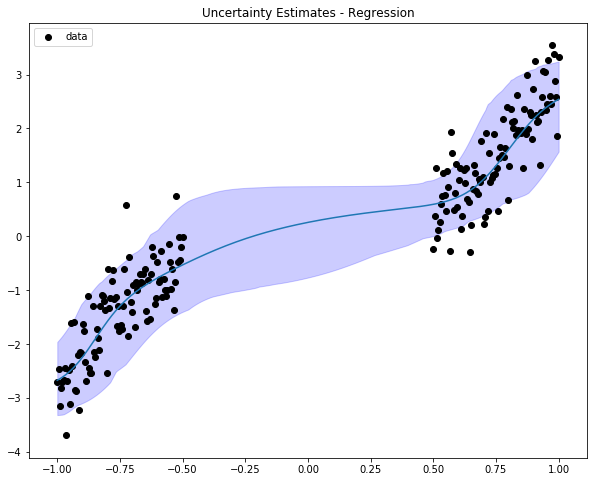

In [84]:
X_test_tensor = torch.as_tensor([X_test]).reshape((-1,1))
pred = swag.predict(X_test_tensor.float(),None, S=200, expanded=True)

mean_ci,up_ci,lower_ci,_ = uncertainty_estimation(swag, X_test, pred, X_valid, y_valid, verbose=True)
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(X_test,mean_ci)
ax.fill_between(X_test, up_ci, lower_ci, color='blue', alpha=0.2)
ax.scatter(X, y, color='black', label='data')
ax.legend(prop={'size':10})
ax.set_title('Uncertainty Estimates - Regression')


Begin uncertainty assessment...
Valid MSE:  0.4143547189893257

Begin uncertainty assessment...
Valid MSE:  0.3571241556072458

Begin uncertainty assessment...
Valid MSE:  0.541595953842662

Begin uncertainty assessment...
Valid MSE:  0.43870952170770267


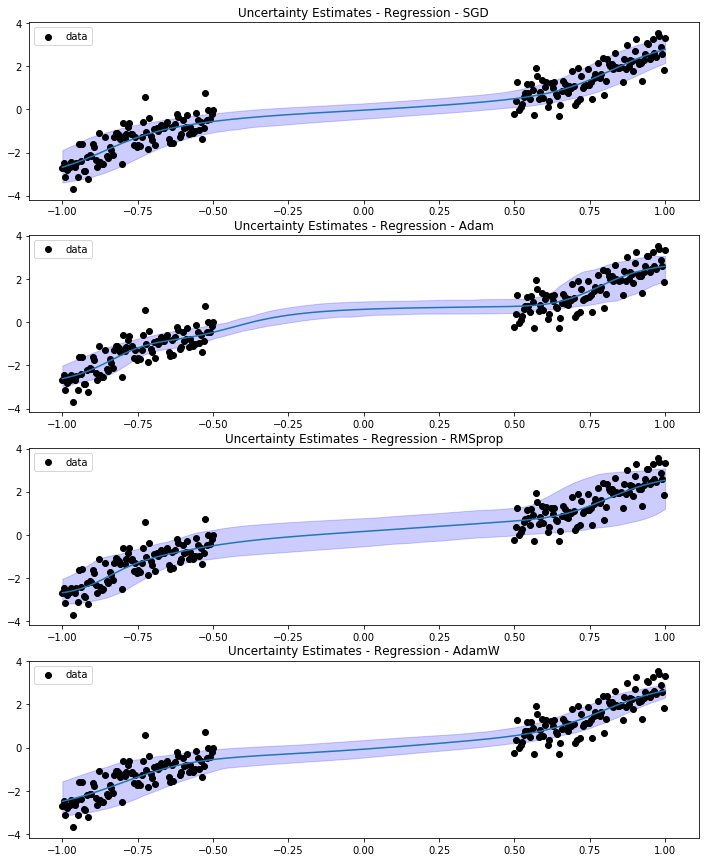

In [94]:
objective = 'regression'
swa_const_lr = 1
loss_fn = nn.MSELoss()
swa_scheduler = LambdaLR

# trying diff optimizer
optimizer_list = [lambda parameters: optim.SGD(parameters, lr=1e-2),
                 lambda parameters: optim.Adam(parameters, lr=1e-2),
                 lambda parameters: optim.RMSprop(parameters, lr=1e-2),
                 lambda parameters: optim.AdamW(parameters, lr=1e-2)]
optimizer_names = ['SGD', 'Adam', 'RMSprop', 'AdamW']

N = len(optimizer_list)
X_test_tensor = torch.as_tensor([X_test]).reshape((-1,1))
fig, ax = plt.subplots(N, 1, figsize=(12, 15))


for i, optimizer in enumerate(optimizer_list):
    swag = SWAG(Regression_linear, K = 4)
    swag.compile_customize_optimizer(objective, swa_const_lr, optimizer, loss_fn, swa_scheduler)
    # Fit swag
    first_mom, second_mom, D = swag.fit(train_gen,
                                    train_epoch=50,
                                    swag_epoch=20,
                                    log_freq=5,verbose=False)
    pred = swag.predict(X_test_tensor.float(),None, S=200, expanded=True)
    mean_ci,up_ci,lower_ci,_ = uncertainty_estimation(swag, X_test, pred, X_valid, y_valid, verbose=True)
    ax[i].plot(X_test,mean_ci)
    ax[i].fill_between(X_test, up_ci, lower_ci, color='blue', alpha=0.2)
    ax[i].scatter(X, y, color='black', label='data')
    ax[i].legend(prop={'size':10})
    ax[i].set_title('Uncertainty Estimates - Regression - {}'.format(optimizer_names[i]))


### summary  

In short, the prior choice does not change the SWAG's performance on uncertainty measurements. For the classification task, the model is only able to capture aleatoric uncertainty but not the epistemic uncertainty for OOD test data points. For the regression task, the model is failed to detect the OOD region in the middle, and probably because it can not distinguish the OOD region from the in-distribution region, which leads to poor epistemic uncertainty. 

### Future Work  
For neural networks, the increased model capacity and lack of regularization are closely related to model miscalibration. In the paper "Guo, C., Pleiss, G., Sun, Y., and Weinberger, K. Q. (2017). On Calibration of Modern Neural Networks. In International Conference on Machine Learning. arXiv: 1706.04599", the authors stresses many different aspects that affect the Calibration of neural networks. Some of them have been tested out, and the remainings are the promising future work to further examine the SWAG's ability on Calibration tasks.  

Model Capacity: although increasing depth and width may reduce classification error, we observe that these increases negatively affect model calibration.

Batch Normalization: although Batch Normalization improves training time, reduces the need for additional regularization, and can in some cases improve the accuracy of networks; the author discovered that models trained with Batch Normalization tend to be more miscalibrated.  

Weight Decay: training with less weight decay has a negative impact on calibration.

Negative Log Likelihood: can be used to indirectly measure model calibration. In practice, there is some disconnect between NLL and accuracy: overfitting to NLL is beneficial to classification accuracy. This disconnect occurs because neural networks can overfit to NLL without overfitting to the 0/1 loss. And This phenomenon renders a concrete explanation of miscalibration: the network learns better classification accuracy at the expense of well-modeled probabilities.
